# สร้างสรุปรายงาน available data จากไฟล์ report *.txt
* ปรับให้คำนวณ ค่าร้อยละ ต่อ expected files เช่น แต่ละช่วงเวลาจะต้องมีเท่าจำนวนสถานี นั่นคือ หากมี 4 สถานี available จะต้องเป็น 4 ดังนั้น เวลาดังกล่าวจะต้องมี missing ของสถานีที่ไม่ครบ
* คำนวณค่าร้อยละ ของข้อมูลที่มีอยู่ ราย 15 นาที แล้วรายงานความสมบูรณ์เป็นร้อยละ สรุปว่าแต่ละชั่วโมงข้อมูลหายไปกี่สถานี สถานีอะไร เวลาใด จำนวนข้อมูล available มีเท่าใด คิดเป็นร้อยละเท่าใด
* คำนวณค่าร้อยละ ของ available ของข้อมูลที่มีอยู่ทั้งหมด กับ ค่าที่ควรจะมี คิดเป็นร้อยละเท่าใดจากจำนวนชั่วโมงทั้งหมด

In [1]:
import os
import datetime
from collections import defaultdict

def parse_timestamp(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y%m%d%H%M")

def read_radar_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        while True:
            timestamp = file.readline().strip()
            if not timestamp:
                break
            available_count = int(file.readline().strip())
            available_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            used_count = int(file.readline().strip())
            used_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            missing_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            if missing_radars == ['']:
                missing_radars = []
            
            data.append({
                'timestamp': parse_timestamp(timestamp),
                'available_count': available_count,
                'available_radars': available_radars,
                'used_count': used_count,
                'used_radars': used_radars,
                'missing_radars': missing_radars
            })
    return data

def generate_report(data):
    if not data:
        return "No data available"
    
    start_time = min(entry['timestamp'] for entry in data)
    end_time = max(entry['timestamp'] for entry in data)
    all_radars = set()
    for entry in data:
        all_radars.update(entry['available_radars'])
    expected_radar_count = len(all_radars)
    
    report = "Enhanced Radar Mosaic Report\n"
    report += "=" * 40 + "\n\n"
    
    report += "Summary:\n"
    report += f"- Start Date/Time: {start_time}\n"
    report += f"- End Date/Time: {end_time}\n"
    report += f"- Number of Entries: {len(data)}\n"
    report += f"- Expected Radars: {', '.join(sorted(all_radars))}\n\n"
    
    report += "Detailed Radar Usage:\n"
    total_available = 0
    total_expected = len(data) * expected_radar_count
    hourly_stats = defaultdict(lambda: {'available': 0, 'missing': defaultdict(int)})
    
    for entry in data:
        timestamp = entry['timestamp']
        hour_key = timestamp.strftime('%Y-%m-%d %H:00')
        available_count = entry['available_count']
        missing_count = expected_radar_count - available_count
        total_available += available_count
        
        report += f"  {timestamp.strftime('%Y-%m-%d %H:%M')} - "
        report += f"Available: {available_count}/{expected_radar_count} "
        report += f"({', '.join(entry['available_radars'])}) | "
        report += f"Used: {entry['used_count']} ({', '.join(entry['used_radars'])}) | "
        if entry['missing_radars']:
            report += f"Missing: {', '.join(entry['missing_radars'])} "
            report += f"({missing_count}/{expected_radar_count}, {missing_count/expected_radar_count*100:.1f}%)\n"
        else:
            report += "Missing: None\n"
        
        hourly_stats[hour_key]['available'] += available_count
        for radar in entry['missing_radars']:
            hourly_stats[hour_key]['missing'][radar] += 1
    
    report += "\nHourly Statistics:\n"
    for hour, stats in hourly_stats.items():
        hourly_expected = 4 * expected_radar_count  # 4 periods per hour
        hourly_available = stats['available']
        hourly_percentage = (hourly_available / hourly_expected) * 100
        report += f"  {hour}: Available data: {hourly_available}/{hourly_expected} ({hourly_percentage:.1f}%)\n"
        if stats['missing']:
            report += "    Missing radars:\n"
            for radar, count in stats['missing'].items():
                report += f"      {radar}: {count}/4 periods\n"
    
    overall_percentage = (total_available / total_expected) * 100
    report += f"\nOverall Data Availability: {total_available}/{total_expected} ({overall_percentage:.1f}%)\n"
    
    return report

def main():
    data_directory = './zProcessing_temp/0hourly_CBB_output/'  
    all_data = []
    
    for filename in os.listdir(data_directory):
        if filename.startswith('data_used_') and filename.endswith('.txt'):
            file_path = os.path.join(data_directory, filename)
            all_data.extend(read_radar_data(file_path))
    
    all_data.sort(key=lambda x: x['timestamp'])
    
    report = generate_report(all_data)
    
    print(report)
    
    with open('enhanced_radar_usage_report.txt', 'w') as f:
        f.write(report)

if __name__ == "__main__":
    main()

Enhanced Radar Mosaic Report

Summary:
- Start Date/Time: 2018-07-17 11:00:00
- End Date/Time: 2018-07-17 13:45:00
- Number of Entries: 12
- Expected Radars: CHN, CRI, LMP, PHS

Detailed Radar Usage:
  2018-07-17 11:00 - Available: 3/4 (CHN, CRI, PHS) | Used: 3 (CHN, CRI, PHS) | Missing: None
  2018-07-17 11:15 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 11:30 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 11:45 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:00 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:15 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:30 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:45 - Available: 3/4 (CRI, LMP, PHS) | Used: 3 (CRI, LMP, PHS) | Mi

In [4]:
import os
import datetime
from collections import defaultdict

def parse_timestamp(timestamp):
    return datetime.datetime.strptime(timestamp, "%Y%m%d%H%M")

def read_radar_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        while True:
            timestamp = file.readline().strip()
            if not timestamp:
                break
            available_count = int(file.readline().strip())
            available_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            used_count = int(file.readline().strip())
            used_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            missing_radars = file.readline().strip()[1:-1].replace("'", "").split(', ')
            if missing_radars == ['']:
                missing_radars = []
            
            data.append({
                'timestamp': parse_timestamp(timestamp),
                'available_count': available_count,
                'available_radars': available_radars,
                'used_count': used_count,
                'used_radars': used_radars,
                'missing_radars': missing_radars
            })
    return data

def generate_report(data):
    if not data:
        return "No data available"
    
    start_time = min(entry['timestamp'] for entry in data)
    end_time = max(entry['timestamp'] for entry in data)
    all_radars = set()
    for entry in data:
        all_radars.update(entry['available_radars'])
        all_radars.update(entry['missing_radars'])
    expected_radar_count = len(all_radars)
    
    report = "Enhanced Radar Mosaic Report\n"
    report += "=" * 40 + "\n\n"
    
    report += "Summary:\n"
    report += f"- Start Date/Time: {start_time}\n"
    report += f"- End Date/Time: {end_time}\n"
    report += f"- Number of Entries: {len(data)}\n"
    report += f"- Expected Radars: {', '.join(sorted(all_radars))}\n\n"
    
    report += "Detailed Radar Usage:\n"
    total_available = 0
    total_expected = len(data) * expected_radar_count
    hourly_stats = defaultdict(lambda: {'available': 0, 'missing': defaultdict(int), 'missing_stations': set()})
    
    for entry in data:
        timestamp = entry['timestamp']
        hour_key = timestamp.strftime('%Y-%m-%d %H:00')
        available_count = entry['available_count']
        missing_count = expected_radar_count - available_count
        total_available += available_count
        
        report += f"  {timestamp.strftime('%Y-%m-%d %H:%M')} - "
        report += f"Available: {available_count}/{expected_radar_count} "
        report += f"({', '.join(entry['available_radars'])}) | "
        report += f"Used: {entry['used_count']} ({', '.join(entry['used_radars'])}) | "
        if entry['missing_radars']:
            report += f"Missing: {', '.join(entry['missing_radars'])} "
            report += f"({missing_count}/{expected_radar_count}, {missing_count/expected_radar_count*100:.1f}%)\n"
        else:
            report += "Missing: None\n"
        
        hourly_stats[hour_key]['available'] += available_count
        for radar in all_radars:
            if radar not in entry['available_radars']:
                hourly_stats[hour_key]['missing'][radar] += 1
                hourly_stats[hour_key]['missing_stations'].add(radar)
    
    report += "\nHourly Statistics:\n"
    for hour, stats in hourly_stats.items():
        hourly_expected = 4 * expected_radar_count  # 4 periods per hour
        hourly_available = stats['available']
        hourly_percentage = (hourly_available / hourly_expected) * 100
        report += f"  {hour}: Available data: {hourly_available}/{hourly_expected} ({hourly_percentage:.1f}%)\n"
        if stats['missing']:
            report += "    Missing radars:\n"
            for radar, count in stats['missing'].items():
                report += f"      {radar}: {count}/4 periods\n"
        
        missing_stations = ', '.join(sorted(stats['missing_stations'])) if stats['missing_stations'] else 'None'
        report += f"    Stations that missed at least one period: {missing_stations}\n"
    
    overall_percentage = (total_available / total_expected) * 100
    report += f"\nOverall Data Availability: {total_available}/{total_expected} ({overall_percentage:.1f}%)\n"
    
    return report

def main():
    data_directory = './zProcessing_temp/0hourly_CBB_output/'  
    all_data = []
    
    for filename in os.listdir(data_directory):
        if filename.startswith('data_used_') and filename.endswith('.txt'):
            file_path = os.path.join(data_directory, filename)
            all_data.extend(read_radar_data(file_path))
    
    all_data.sort(key=lambda x: x['timestamp'])
    
    report = generate_report(all_data)
    
    print(report)
    
    with open('enhanced_radar_usage_report.txt', 'w') as f:
        f.write(report)

if __name__ == "__main__":
    main()



Enhanced Radar Mosaic Report

Summary:
- Start Date/Time: 2018-07-17 11:00:00
- End Date/Time: 2018-07-17 13:45:00
- Number of Entries: 12
- Expected Radars: CHN, CRI, LMP, PHS

Detailed Radar Usage:
  2018-07-17 11:00 - Available: 3/4 (CHN, CRI, PHS) | Used: 3 (CHN, CRI, PHS) | Missing: None
  2018-07-17 11:15 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 11:30 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 11:45 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:00 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:15 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:30 - Available: 4/4 (CHN, CRI, LMP, PHS) | Used: 4 (CHN, CRI, LMP, PHS) | Missing: None
  2018-07-17 12:45 - Available: 3/4 (CRI, LMP, PHS) | Used: 3 (CRI, LMP, PHS) | Mi

C:\Users\Admin\AppData\Local\Temp\ipykernel_14856\3832367630.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


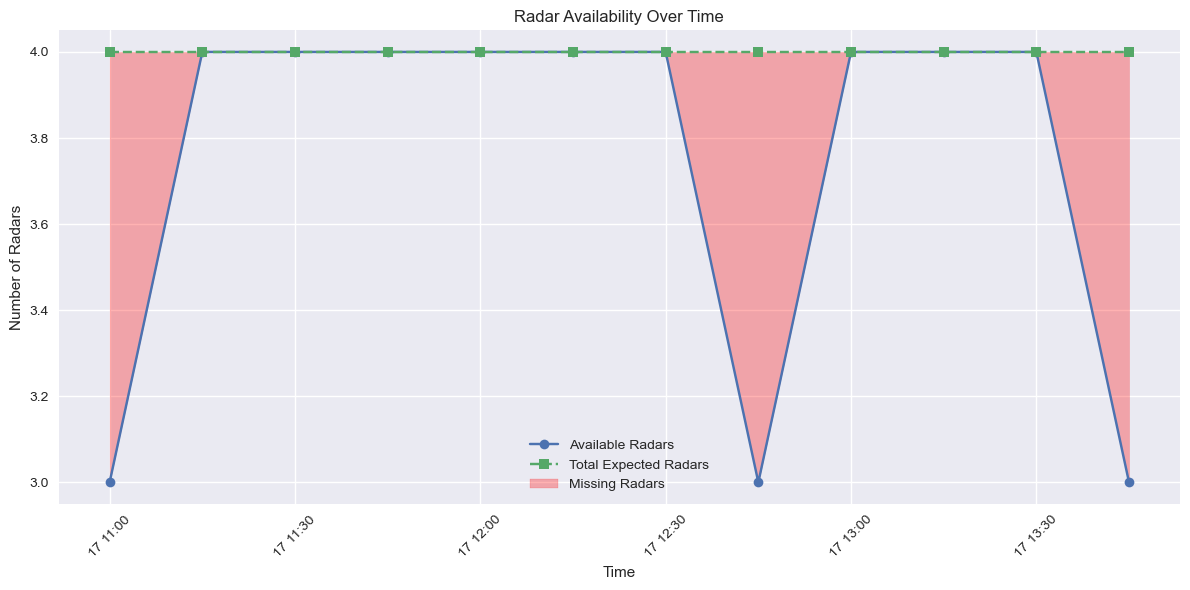

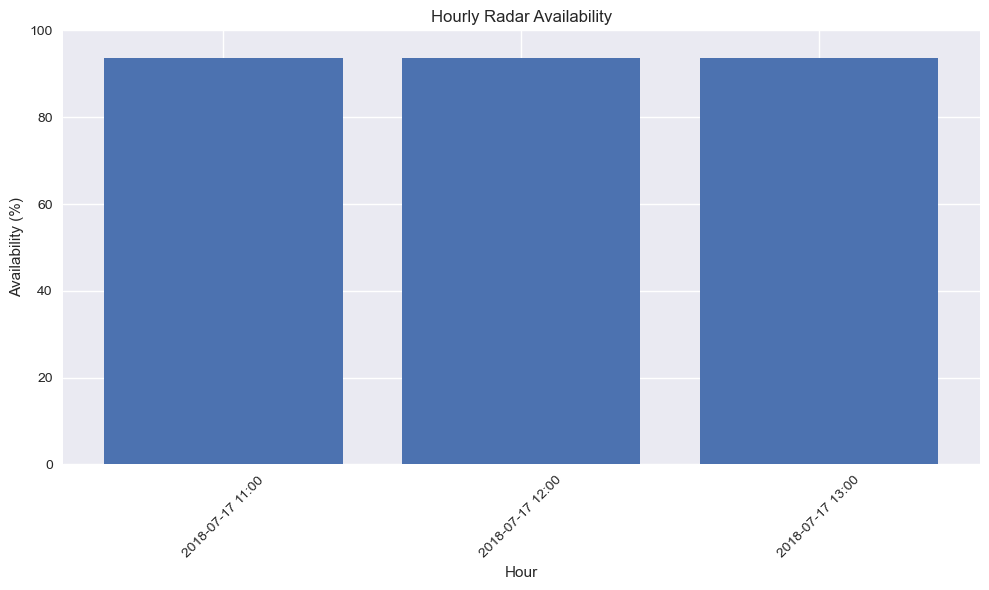

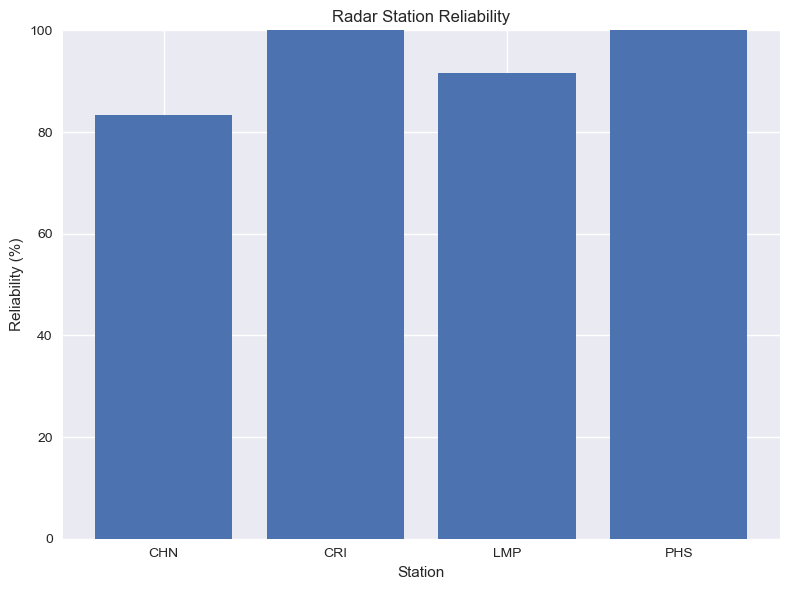

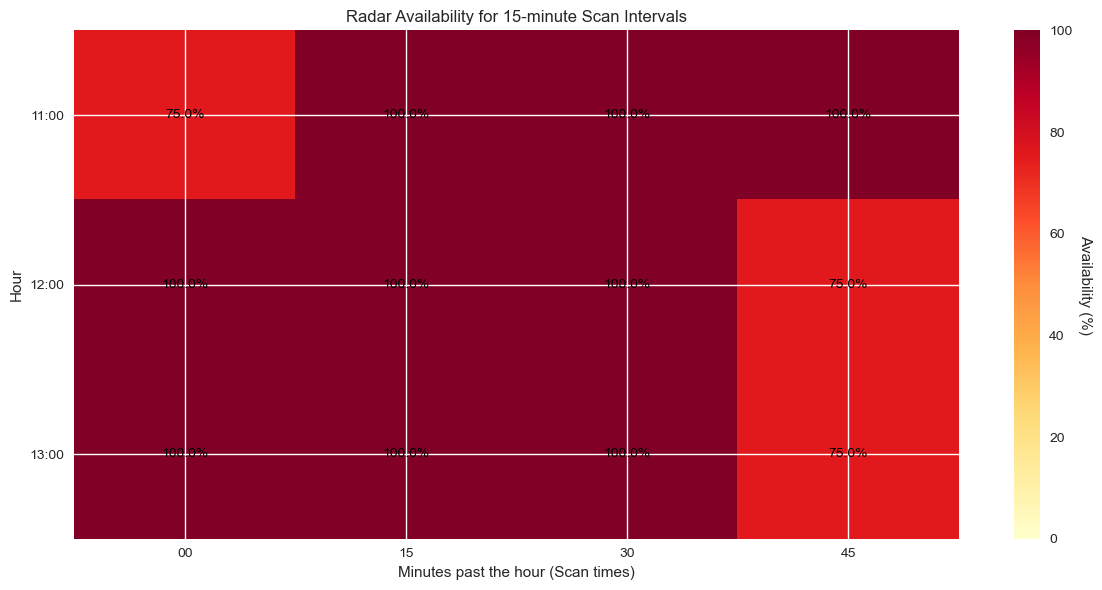

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
plt.style.use('seaborn')

def parse_time(time_str):
    return datetime.strptime(time_str, '%Y-%m-%d %H:%M')

# Data structure based on your report
data = [
    {'timestamp': parse_time('2018-07-17 11:00'), 'available': 3, 'total': 4, 'available_radars': ['CHN', 'CRI', 'PHS']},
    {'timestamp': parse_time('2018-07-17 11:15'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 11:30'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 11:45'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 12:00'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 12:15'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 12:30'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 12:45'), 'available': 3, 'total': 4, 'available_radars': ['CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 13:00'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 13:15'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 13:30'), 'available': 4, 'total': 4, 'available_radars': ['CHN', 'CRI', 'LMP', 'PHS']},
    {'timestamp': parse_time('2018-07-17 13:45'), 'available': 3, 'total': 4, 'available_radars': ['CRI', 'LMP', 'PHS']}
]

def plot_radar_availability(data):
    timestamps = [entry['timestamp'] for entry in data]
    available = [entry['available'] for entry in data]
    total = [entry['total'] for entry in data]

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, available, marker='o', linestyle='-', label='Available Radars')
    plt.plot(timestamps, total, marker='s', linestyle='--', label='Total Expected Radars')
    plt.fill_between(timestamps, available, total, alpha=0.3, color='red', label='Missing Radars')
    
    plt.title('Radar Availability Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Radars')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_hourly_availability(hourly_stats):
    hours = list(hourly_stats.keys())
    availability = [stats['available'] / 16 * 100 for stats in hourly_stats.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(hours, availability)
    plt.title('Hourly Radar Availability')
    plt.xlabel('Hour')
    plt.ylabel('Availability (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_station_reliability(data):
    stations = ['CHN', 'CRI', 'LMP', 'PHS']
    reliability = {station: sum(1 for entry in data if station in entry['available_radars']) / len(data) * 100 for station in stations}

    plt.figure(figsize=(8, 6))
    plt.bar(stations, [reliability[station] for station in stations])
    plt.title('Radar Station Reliability')
    plt.xlabel('Station')
    plt.ylabel('Reliability (%)')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_15min_availability_large_scale(data, days_per_plot=7):
    # Group data by day and hour
    daily_data = {}
    for entry in data:
        day = entry['timestamp'].date()
        hour = entry['timestamp'].hour
        minute = entry['timestamp'].minute
        if day not in daily_data:
            daily_data[day] = {}
        if hour not in daily_data[day]:
            daily_data[day][hour] = {}
        daily_data[day][hour][minute] = entry['available'] / entry['total'] * 100
    
    # Prepare data for plotting
    days = sorted(daily_data.keys())
    intervals = [0, 15, 30, 45]
    
    # Split into weekly plots
    for week_start in range(0, len(days), days_per_plot):
        week_days = days[week_start:week_start+days_per_plot]
        availability_data = []
        
        for day in week_days:
            for hour in range(24):
                hour_availability = [daily_data.get(day, {}).get(hour, {}).get(minute, np.nan) for minute in intervals]
                availability_data.append(hour_availability)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(15, 10))
        im = ax.imshow(availability_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
        
        # Set up the axes
        ax.set_xticks(np.arange(len(intervals)))
        ax.set_xticklabels([f"{minute:02d}" for minute in intervals])
        
        # Set y-axis ticks to show dates and hours
        y_ticks = np.arange(0, len(availability_data), 24)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([week_days[i].strftime('%Y-%m-%d') for i in range(len(y_ticks))])
        
        # Add hour labels on the right side
        ax2 = ax.twinx()
        ax2.set_yticks(np.arange(12, len(availability_data), 24))
        ax2.set_yticklabels([f"{h:02d}:00" for h in range(0, 24, 2)])
        
        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel("Availability (%)", rotation=-90, va="bottom")
        
        # Set title and labels
        start_date = week_days[0].strftime('%Y-%m-%d')
        end_date = (week_days[-1] + timedelta(days=1)).strftime('%Y-%m-%d')
        ax.set_title(f"Radar Availability: {start_date} to {end_date}")
        ax.set_xlabel("Minutes past the hour (Scan times)")
        ax.set_ylabel("Date")
        
        fig.tight_layout()
        plt.show()


# Call the functions to generate the plots
plot_radar_availability(data)
plot_hourly_availability({
    '2018-07-17 11:00': {'available': 15},
    '2018-07-17 12:00': {'available': 15},
    '2018-07-17 13:00': {'available': 15}
})
plot_station_reliability(data)
plot_15min_availability(data)